In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
#constantes
mu0 = 1.2566370612e-6 #N/A^2
pi = np.pi

In [3]:
class CurrentSheet:
    def __init__(self, ra, rb, p, current=1):
        self.ra = ra
        self.rb = rb
        self.p = p
        self.pnorm = pnorm = np.linalg.norm(p)
        self.current = current
        self.current_density = current/pnorm
        #calculate the normal which is perpendicular to rb-ra and p
        normal = np.cross(rb-ra, p)
        self.normal = normal/np.linalg.norm(normal)
    def B(self, r2):
        ra, rb, p = self.ra, self.rb, self.p
        pnorm = self.pnorm
        #compute Br
        Br = mu0 * self.current_density
        """
        Compute the magnetic field at a point r2 due to a finite-size current sheet.
        
        Parameters:
            ra (np.array): Start point of the current sheet (3D vector)
            rb (np.array): End point of the current sheet (3D vector)
            p (np.array): Width vector perpendicular to the current sheet
            r2 (np.array): Observation point (3D vector)
            Br (float): Remanent magnetic field (T)
            alpha (float): Aspect ratio of the sheet (w = alpha * |rb - ra|)
        
        Returns:
            np.array: Magnetic field vector at r2
        """

        # Compute fundamental quantities
        C = np.linalg.norm(rb - ra)**2
        A = np.linalg.norm(r2 - ra)**2
        B = np.dot(r2 - ra, rb - ra)

        # Define s-dependent parameters
        def A_s(s):
            return A - 2 * s * np.dot(r2 - ra, p) + pnorm**2 * s**2

        def B_s(s):
            return B  # B(s) is constant

        # Compute integrals numerically over s in [-1/2, 1/2]
        s_vals = np.linspace(-0.5, 0.5, 1000)
        J1 = np.trapz((C - B_s(s_vals)) / np.sqrt(A_s(s_vals) - 2 * B_s(s_vals) + C), s_vals)
        J2 = np.trapz(s_vals * (C - B_s(s_vals)) / np.sqrt(A_s(s_vals) - 2 * B_s(s_vals) + C), s_vals)
        J3 = np.trapz(B_s(s_vals) / np.sqrt(A_s(s_vals)), s_vals)
        J4 = np.trapz(s_vals * B_s(s_vals) / np.sqrt(A_s(s_vals)), s_vals)

        # Correcting for the removal of α using sqrt(C)
        prefactor = (Br * pnorm * np.sqrt(C)) / (4 * np.pi)

        # Compute the magnetic field components
        B_field = prefactor * ((C - B) * J1 + B * J3) * np.cross(rb - ra, r2 - ra) / (A * C - B**2)
        B_field += prefactor * ((C - B) * J2 + B * J4) * np.cross(rb - ra, p) / np.linalg.norm(np.cross(rb - ra, p))

        return B_field

    @property
    def outline(self):
        p, ra,rb = self.p, self.ra, self.rb
        return np.array([ra+p, rb+p, rb-p, ra-p, ra+p])

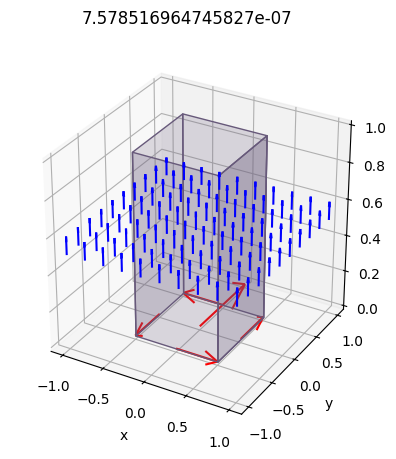

In [58]:

#plto the sheets

# Plot the current sheet outline in 3D as full plane
outline = current_sheet.outline
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

# Create a current sheet
ra = np.array([0, 0, 0])
rb = np.array([0, 0, 1])
p = np.array([0, 1, 0])
current_sheet = CurrentSheet(ra, rb, p)
current_sheets = []

#create a square of current sheets
ra_L = [np.array(eee)+np.array((-.5,-.5,0)) for eee in [(0,0,0), (0,1,0), (1,0,0), (1,1,0)]]
rb_L = [np.array((0,0,1))+eee for eee in ra_L]
p_L = [np.array(eee)/2 for eee, r_a in zip([(0,-1,0), (-1,0,0), (1,0,0), (0,1,0)], ra_L)]
ra_L = [eee-aaa for eee,aaa in zip(ra_L,p_L)]
rb_L = [eee-aaa for eee,aaa in zip(rb_L,p_L)]
for i in range(4):
    current_sheets.append(CurrentSheet(ra_L[i], rb_L[i], p_L[i]))
    ax.quiver(*ra_L[i], *(p_L[i]), color='r')

#plot all the sheets
for current_sheet in current_sheets:
    verts = [current_sheet.outline[:-1]]
    rect = Poly3DCollection(verts, facecolors="#67597A", edgecolors='#67597A', alpha=0.2)
    ax.add_collection3d(rect)

#plot one sheet
verts = [current_sheet.outline[:-1]]
rect = Poly3DCollection(verts, facecolors="#67597A", edgecolors='#67597A', alpha=0.2)
ax.add_collection3d(rect)

ax.quiver(*ra, *(p), color='r')
# Create and add the polygon
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#set axes equal
ax.set_box_aspect([1,1,1])

z=0.5
# Calculate the magnetic field vectors on the z=0 plane
x= np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
B = np.array([current_sheet.B(np.array([xi, yi, z])) for xi in x for yi in y])
B = B.reshape(len(x), len(y), 3)

# Extract the x and y components of the magnetic field
Bx, By = B[:, :, 0], B[:, :, 1]

norm = np.linalg.norm(B, axis=2)
maxnorm = np.max(norm)
plt.suptitle(str(maxnorm))

# Create a meshgrid for the x and y coordinates
X, Y = np.meshgrid(x, y)

# Plot the quiver plot for the magnetic field
ax.quiver(X, Y, z, Bx, By, z, length=0.1, normalize=True, color='b')

plt.show()

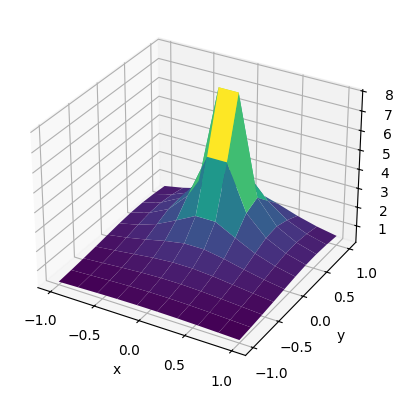

In [51]:
#plot the magnetic field intensity calculated previously
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(X, Y, np.linalg.norm(B, axis=2), cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('B')
plt.show()